# Descubriendo Bitcoin/ *Discovering Bitcoin*

Este es la primer parada de una larga serie de trabajos que tendrán como eje las series temporales, su análisis, exploración, preparación y modelado. Nos adentraremos en los distintos modelos de ML existentes y usaremos, casi como un desafío, el dataset del precio de Bitcoin, una serie de tiempo no estacionaria y -sin duda- de dificil predicción.

*Here begins the initial step in a comprehensive series of projects focused on time series data, encompassing analysis, exploration, preparation, and modeling. We will venture into diverse machine learning models, and as a formidable test, we will tackle the Bitcoin price dataset—an inherently non-stationary time series, presenting a formidable challenge in prediction.*


## Exploración de datos/ *Data Exploration*

El dataset que usaremos lo encontrarás en www.kaggle.com. Es un dataset muy sencillo donde figura los datos diarios de una vela japonesa. En nuestro caso, crearemos un df univariado, es decir, con un solo feature que será el precio de cierre.  

*The dataset we will be using can be found on www.kaggle.com. It is a straightforward dataset containing daily Japanese candlestick data. In our case, we will create a univariate dataframe, meaning it will have only one feature, which will be the closing price.*

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import requests

# Date
import datetime as dt
from datetime import date, timedelta, datetime
import time

# EDA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Cargamos el dataset y establecemos la fecha como indice
#We load the dataset and set the date as the index
df = pd.read_csv('BTC.csv',
            index_col = "date",
            parse_dates = True).asfreq("D")

In [4]:
df.head()

,ticker,open,high,low,close
date,,,,,
2010-07-17,BTC,0.04951,0.04951,0.04951,0.04951
2010-07-18,BTC,0.04951,0.08585,0.04951,0.08584
2010-07-19,BTC,0.08584,0.09307,0.07723,0.08080
2010-07-20,BTC,0.08080,0.08181,0.07426,0.07474
2010-07-21,BTC,0.07474,0.07921,0.06634,0.07921


In [5]:
df.shape

(4803, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4803 entries, 2010-07-17 to 2023-09-09
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  4803 non-null   object 
 1   open    4803 non-null   float64
 2   high    4803 non-null   float64
 3   low     4803 non-null   float64
 4   close   4803 non-null   float64
dtypes: float64(4), object(1)
memory usage: 225.1+ KB


In [7]:
#Eliminamos las columnas que no nos interesan
#We remove the columns that are not of interest.
df = df.drop(['ticker','open','high', 'low'], axis=1)

In [8]:
display(df)

,close
date,
2010-07-17,0.04951
2010-07-18,0.08584
2010-07-19,0.08080
2010-07-20,0.07474
2010-07-21,0.07921
...,...
2023-09-05,25722.40000
2023-09-06,25709.90000
2023-09-07,26146.70000


### Visualización / *Visualization*

Como soy un poco trader y, aún más, un entusiasta del cripto-mundo, tengo plena conciencia de que el gráfico histórico de BTC muestra un crecimiento exponencial y por ende, su volatilidad es vertiginosa. Por esta razón, crearemos un feature que será la versión logarítmica del precio. La transformación logarítmica hace que la dispersión sea más o menos
constante a medida que crece la media.  

*As I am a trader myself and, even more so, a crypto enthusiast, I am fully aware that the historical chart of BTC displays exponential growth, and therefore, its volatility is staggering. For this reason, we will create a feature that will be the logarithmic version of the price. The logarithmic transformation makes the dispersion more or less constant as the mean grows*

In [9]:
df['log_close'] = np.log(df['close'])

Comparemos ahora la gráfica standard con la logarítmica:

*Let's now compare the standard chart with the logarithmic one:*

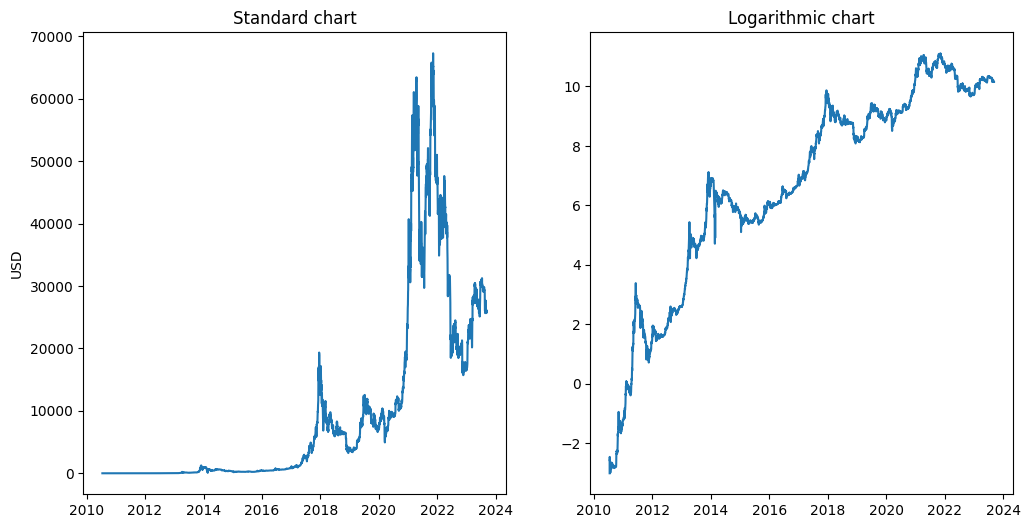

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(df['close'])
axs[1].plot(df['log_close'])

axs[0].set_ylabel('USD')
axs[0].set_title('Standard chart')
axs[1].set_title('Logarithmic chart')
plt.show()

Una opción interesante es poder ver la misma gráfica desde distintos rangos de tiempo y así, limpiar la volatilidad circunstancial. En este caso, usaremos el promedio anual y mensual.

*An interesting option is to be able to view the same chart over different timeframes, thus smoothing out circumstantial volatility. In this case, we will use the annual and monthly averages.*

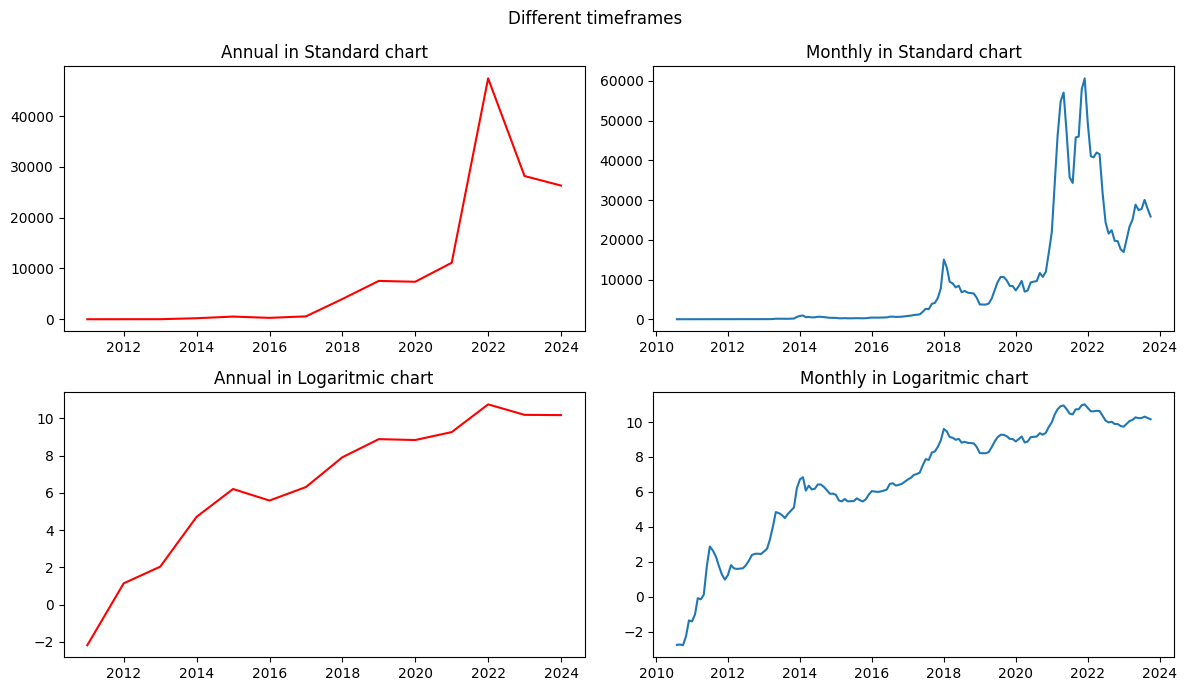

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

axs[0, 0].plot(df['close'].resample('Y').mean(), color='red')
axs[0, 1].plot(df['close'].resample('M').mean())
axs[1, 0].plot(df['log_close'].resample('Y').mean(), color='red')
axs[1, 1].plot(df['log_close'].resample('M').mean())

axs[0, 0].set_title('Annual in Standard chart')
axs[0, 1].set_title('Monthly in Standard chart')
axs[1, 0].set_title('Annual in Logaritmic chart')
axs[1, 1].set_title('Monthly in Logaritmic chart')

plt.suptitle('Different timeframes')
plt.tight_layout()
plt.show()

### Cálculo de la diferencia/ *Difference calculation*

La transformación que elimina la tendencia (o lo que es lo mismo, induce
estacionariedad en la media) es la diferenciación. Tomar una diferencia regular
consiste en calcular la diferencia entre cada dato y el
anterior.

*The transformation that removes the trend (or equivalently, induces stationarity in the mean) is differencing. Taking a regular difference involves calculating the difference between each data point and the previous one.*



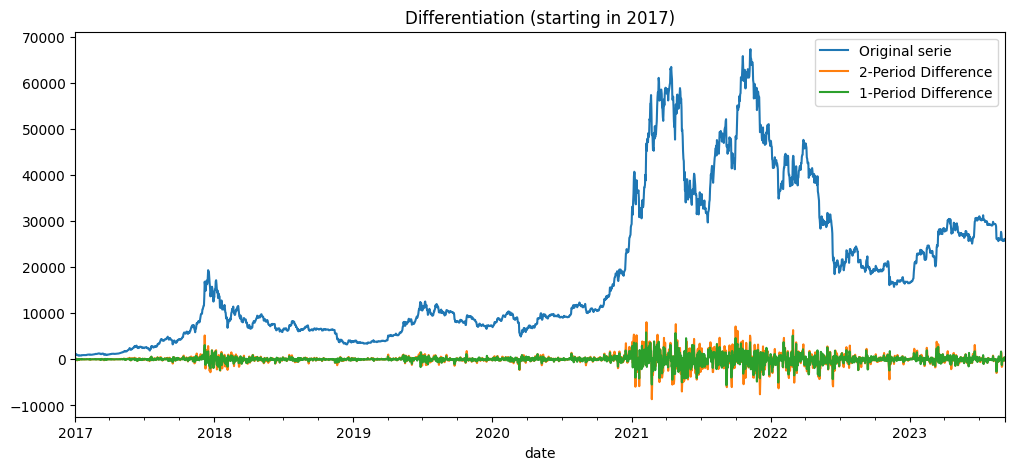

In [12]:
#realizamos la diferenciación desde 2017
#We perform differencing starting from 2017
dfDiff = df.loc['2017-01-01':]
diff_df = pd.concat([dfDiff['close'], dfDiff['close'].diff(2),dfDiff['close'].diff()], axis=1)

diff_df.columns = ['Original serie', '2-Period Difference','1-Period Difference']

diff_df.plot(figsize=(12, 5), legend=True)
plt.title('Differentiation (starting in 2017)')
plt.show()


Podemos indagar el precio promedio para cada mes y así observar en que momento del año BTC suele tener mejor rendimiento.

*We can inquire about the average price for each month and thus observe at which time of the year BTC tends to have better performance.*


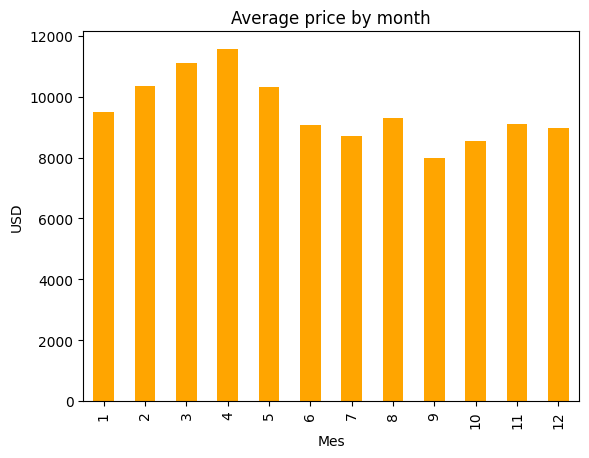

In [13]:
df['close'].groupby(df.index.month).mean().plot(kind='bar', color='orange')
plt.title('Average price by month')
plt.ylabel('USD')
plt.xlabel('Mes')
plt.show()

Los primeros 4 meses del año tienden a ser los más bullish.

*The first 4 months of the year tend to be the most bullish.*

### Grafico de variación porcentual/ *Percentage change chart*

Los gráficos de variación porcentual ayudan a comprender mejor las fluctuaciones relativas en lugar de las fluctuaciones absolutas de precios. Esto permite evaluar la volatilidad y las tendencias de manera más efectiva.

*Percentage change charts help to better understand relative fluctuations instead of absolute price fluctuations. This enables a more effective assessment of volatility and trends.*

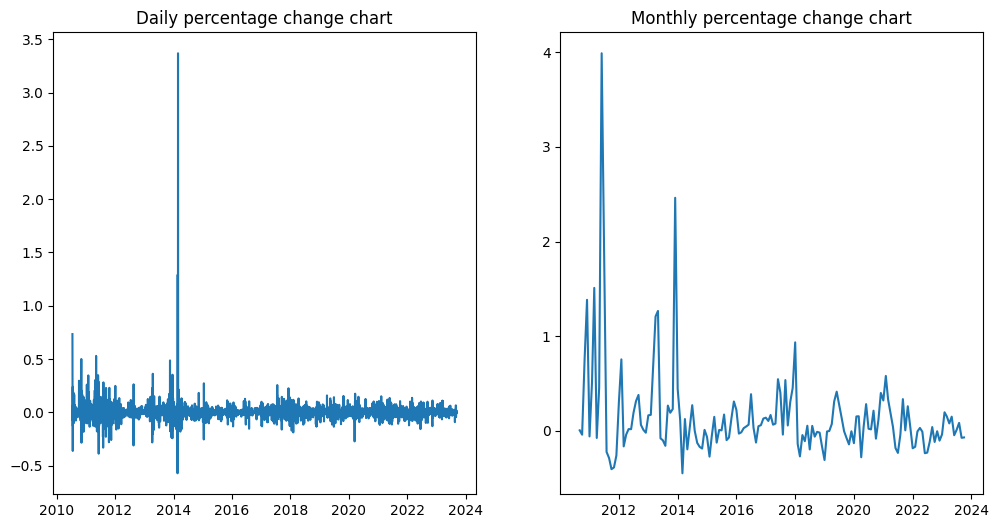

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

media_mensual = df['close'].resample('M').mean()

axs[0].plot(df['close'].pct_change())
axs[1].plot(media_mensual.pct_change())
axs[0].set_title('Daily percentage change chart')
axs[1].set_title('Monthly percentage change chart')
plt.show()

### Descomposición/ *decomposition*

La descomposición de series temporales resulta útil para desentrañar las razones subyacentes de las variaciones en los datos a lo largo del tiempo y anticipar valores futuros. La separación de los componentes -tendencia, estacionalidad, ruido-, nos permite analizar y modelar cada uno de ellos de manera individual, lo que simplifica la detección de las tendencias de mercado y los patrones estacionales en los precios de los activos.

*Time series decomposition is useful for unraveling the underlying reasons behind data variations over time and for anticipating future values. Separating the components - trend, seasonality, noise - allows us to analyze and model each of them individually, making it easier to detect market trends and seasonal patterns in asset prices.*

Realizamos sobre la serie original una descomposición multiplicativa y observamos que no es posible determinar ninguna tendencia ni estacionalidad:

*We performed a multiplicative decomposition on the original series and observed that it's not possible to determine any trend or seasonality:*

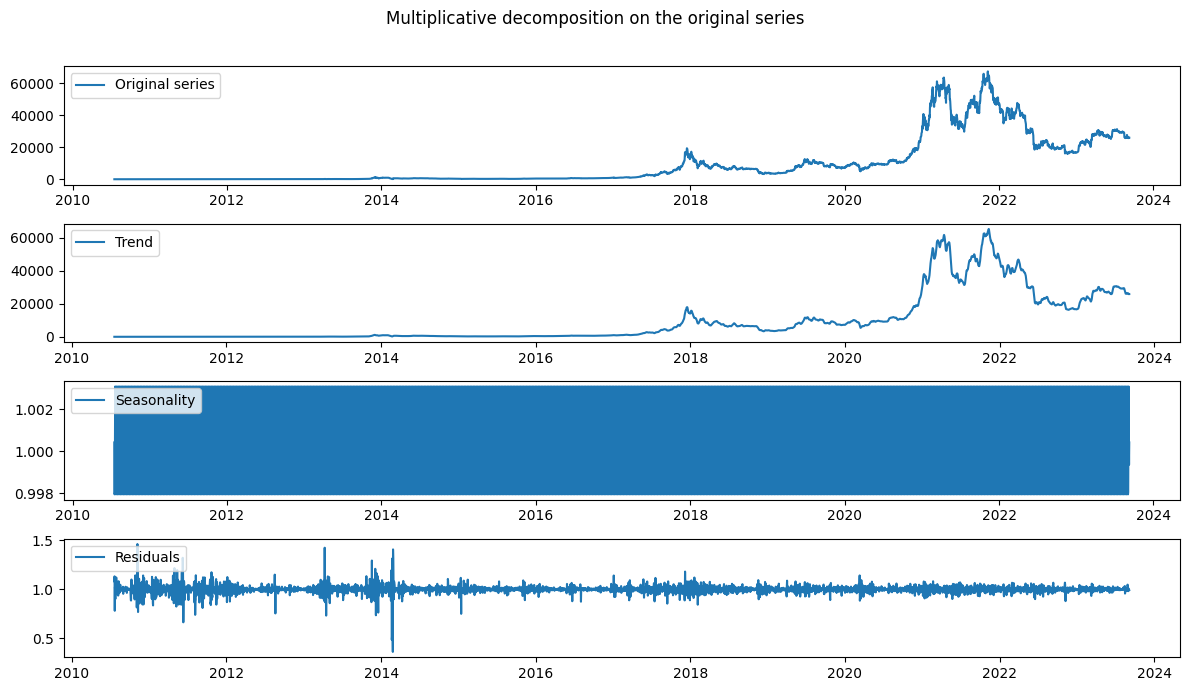

In [15]:
import statsmodels.api as sm

# Realizamos la descomposición multiplicativa
# We perform the multiplicative decomposition
descomposicion_O = sm.tsa.seasonal_decompose(df['close'], model='multiplicative')

# Obtenemos sus componentes
# We obtain its components
tendencia_O = descomposicion_O.trend
estacionalidad_O = descomposicion_O.seasonal
residuos_O = descomposicion_O.resid

# Graficamos
# We plot
plt.figure(figsize=(12, 7))
plt.subplot(411)
plt.plot(df['close'], label='Original series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(tendencia_O, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(estacionalidad_O, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuos_O, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.suptitle('Multiplicative decomposition on the original series', fontsize=12)
plt.subplots_adjust(top=0.9)
plt.show()

Si realizamos la descomposición sobre el gráfico en su versión logarítmica podemos detectar, al menos, una tendencia.

*If we perform the decomposition on the graph in its logarithmic version, we can detect at least one trend.*

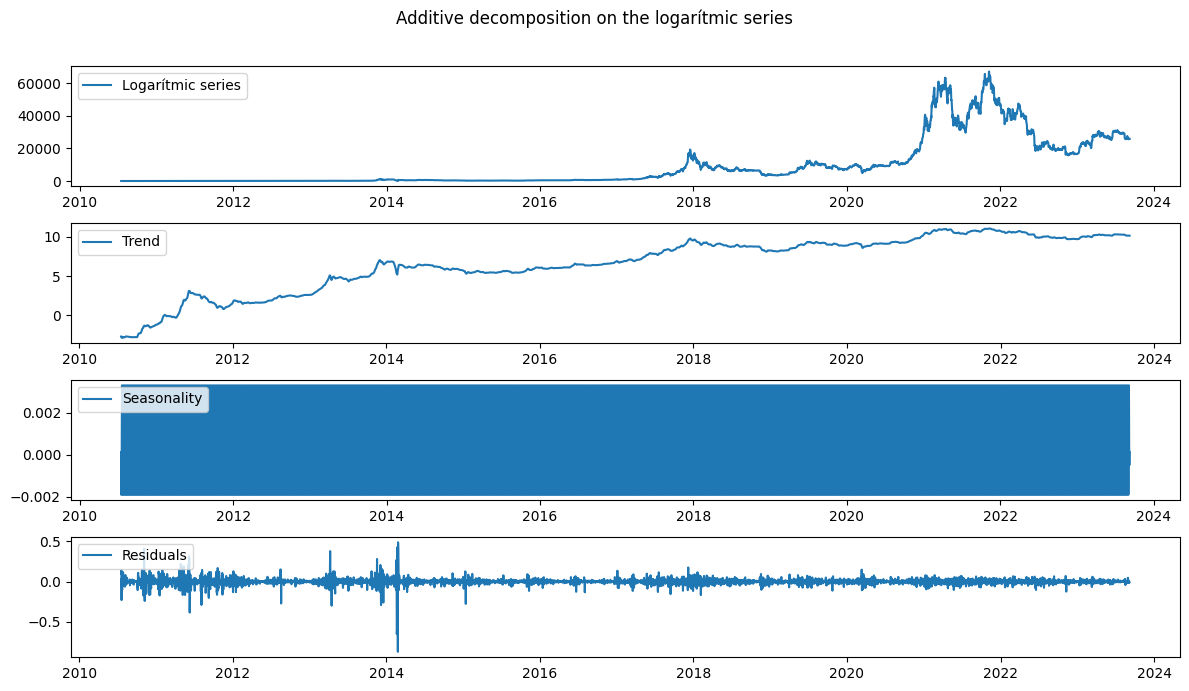

In [16]:
import statsmodels.api as sm

descomposicion_L = sm.tsa.seasonal_decompose(df['log_close'], model='additive')

tendencia_L = descomposicion_L.trend
estacionalidad_L = descomposicion_L.seasonal
residuos_L = descomposicion_L.resid

plt.figure(figsize=(12, 7))
plt.subplot(411)
plt.plot(df['close'], label='Logarítmic series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(tendencia_L, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(estacionalidad_L, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuos_L, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.suptitle('Additive decomposition on the logarítmic series', fontsize=12)
plt.subplots_adjust(top=0.9)
plt.show()

Relación entre la gráfica observada y la tendencia:

*Relationship between the observed graph and the trend:*

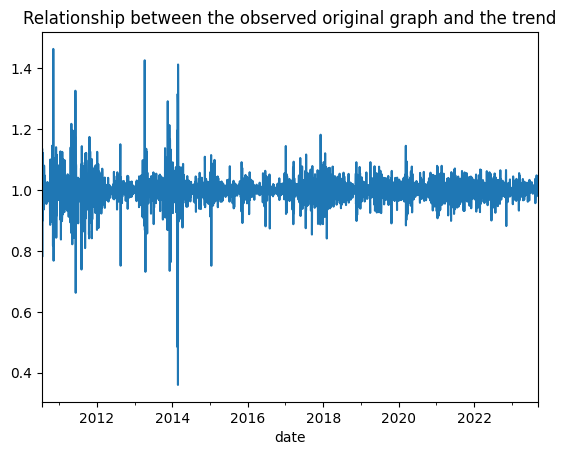

In [20]:
pd.DataFrame(descomposicion_O.observed/tendencia_O).plot(legend=False)
plt.title('Relationship between the observed original graph and the trend')
plt.show()

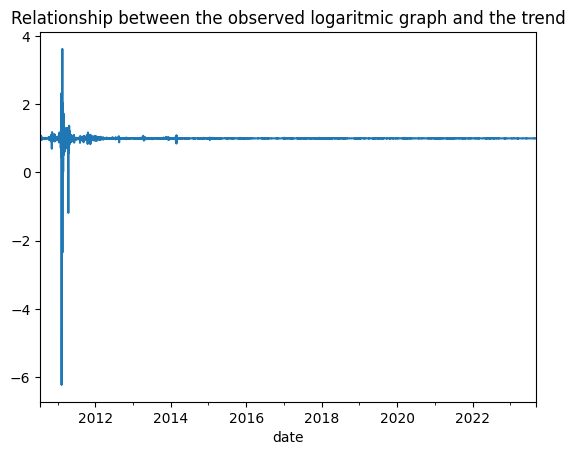

In [21]:
pd.DataFrame(descomposicion_L.observed/tendencia_L).plot(legend=False)
plt.title('Relationship between the observed logaritmic graph and the trend')
plt.show()